In [ ]:
%pip install -r ../requirements.txt



In [1]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Short-term EMA (12-period)
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    
    # Long-term EMA (26-period)
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    
    # MACD Line
    macd_line = short_ema - long_ema
    
    # Signal Line (9-period EMA of MACD Line)
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    
    # MACD Histogram (difference between MACD Line and Signal Line)
    macd_histogram = macd_line - signal_line
    
    return macd_line, signal_line, macd_histogram

def feature_engineering(data):
    # Feature: 10-period moving average
    data['MA10'] = data['Close'].rolling(window=10).mean()

    # Feature: 50-period moving average
    data['MA50'] = data['Close'].rolling(window=50).mean()

    # Feature: Close-to-Close percentage change
    data['Pct_Change'] = data['Close'].pct_change()

    # Feature: High-Low spread
    data['HL_Spread'] = data['High'] - data['Low']

    # Add RSI as a feature
    data['RSI'] = calculate_rsi(data)

    # Add MACD Line, Signal Line, and MACD Histogram as features
    data['MACD_Line'], data['Signal_Line'], data['MACD_Histogram'] = calculate_macd(data)

    # Calculate the percentage above/below current price for moving averages
    data['MA10_pct'] = (data['MA10'] - data['Close']) / data['Close'] * 100
    data['MA50_pct'] = (data['MA50'] - data['Close']) / data['Close'] * 100

    # Drop any rows with missing values due to moving averages
    data = data.dropna()

    return data

features = ['MA10_pct', 'MA50_pct', 'Pct_Change', 'HL_Spread', 'RSI', 'MACD_Line', 'Signal_Line', 'Volume','HL_Spread']

In [3]:
import pandas as pd
import glob

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# Load the CSV file, assuming it's saved as 'data.csv'
#data = pd.read_csv('../sampledata/MSFT_5d_1m_intraday_last_week.csv', parse_dates=['Datetime'], index_col='Datetime')
#data = pd.read_csv('../sampledata/AAPL_intraday_data.csv', parse_dates=['Datetime'], index_col='Datetime')
# Get a list of all files with the name like 'AAPL_15min_intraday_data_2024-??'

data = pd.DataFrame()

file_list = glob.glob('../sampledata/BTC-USD_1mo_15m_2024_??_intraday.csv')

print(file_list)

# Initialize an empty DataFrame
data = pd.DataFrame()

# Loop through each file and concatenate its data to the 'data' dataframe
for file in file_list:
    df = pd.read_csv(file, parse_dates=['Datetime'], index_col='Datetime')
    data = pd.concat([data, df])

# Display the updated 'data' dataframe
#print(data)
#data = data[(data.index.time >= pd.to_datetime('09:30:00').time()) &
#            (data.index.time <= pd.to_datetime('16:00:00').time())]

# Display the data to ensure it's loaded correctly
print(data)


['../sampledata\\BTC-USD_1mo_15m_2024_07_intraday.csv', '../sampledata\\BTC-USD_1mo_15m_2024_08_intraday.csv', '../sampledata\\BTC-USD_1mo_15m_2024_09_intraday.csv']
                             Open          High           Low         Close     Adj Close    Volume
Datetime                                                                                           
2024-07-23 00:00:00  67571.187500  67652.648438  67527.351562  67652.648438  67652.648438         0
2024-07-23 00:15:00  67674.265625  67763.875000  67621.562500  67644.507812  67644.507812   1581056
2024-07-23 00:30:00  67652.304688  67681.773438  67624.132812  67632.593750  67632.593750  13160448
2024-07-23 00:45:00  67615.398438  67698.945312  67562.335938  67563.687500  67563.687500         0
2024-07-23 01:00:00  67519.796875  67519.796875  67303.062500  67377.093750  67377.093750  12656640
...                           ...           ...           ...           ...           ...       ...
2024-09-20 12:15:00  63434.914062 

2. Feature Engineering
With your data, the next step is to create features that your machine learning model can learn from. These might include:

Moving averages
Price changes over time (e.g., close-to-close percentage change)
High-Low spread
Here's how to create some simple features:

In [4]:
from featureengineering import feature_engineering
from featureengineering import features


print(features)
# Apply the feature engineering function to the data
data = feature_engineering(data)
print(data)



['MA10_pct', 'MA50_pct', 'Pct_Change', 'HL_Spread', 'RSI', 'MACD_Line', 'Signal_Line', 'Volume']
                             Open          High           Low         Close     Adj Close    Volume          MA10          MA50  Pct_Change   HL_Spread        RSI   MACD_Line  Signal_Line  MACD_Histogram  MA10_pct  MA50_pct
Datetime                                                                                                                                                                                                                       
2024-07-23 12:15:00  66583.242188  66694.429688  66581.531250  66581.531250  66581.531250  64774144  66757.592188  67005.911562   -0.000329  112.898438  39.703201  -82.515565   -71.157151      -11.358414  0.264429  0.637384
2024-07-23 12:30:00  66516.414062  66516.414062  66409.539062  66446.179688  66446.179688         0  66710.058594  66981.782187   -0.002033  106.875000  37.946955  -98.530831   -76.631887      -21.898944  0.397132  0.806070
2024-07

Scale the features

In [5]:

from sklearn.preprocessing import StandardScaler

# Define the new percentage-based features


# Scale the features
scaler = StandardScaler()
data_scaled = data.copy()

data_scaled[features] = scaler.fit_transform(data[features])

print(data_scaled)


                             Open          High           Low         Close     Adj Close    Volume          MA10          MA50  Pct_Change  HL_Spread       RSI  MACD_Line  Signal_Line  MACD_Histogram  MA10_pct  MA50_pct
Datetime                                                                                                                                                                                                                    
2024-07-23 12:15:00  66583.242188  66694.429688  66581.531250  66581.531250  66581.531250 -0.207724  66757.592188  67005.911562   -0.101527  -0.424690 -0.668105  -0.359874    -0.326007      -11.358414  0.465264  0.457804
2024-07-23 12:30:00  66516.414062  66516.414062  66409.539062  66446.179688  66446.179688 -0.488080  66710.058594  66981.782187   -0.635215  -0.462331 -0.776929  -0.433624    -0.352742      -21.898944  0.704907  0.586231
2024-07-23 12:45:00  66428.265625  66498.859375  66423.953125  66498.859375  66498.859375 -0.488080  66663.347656  6

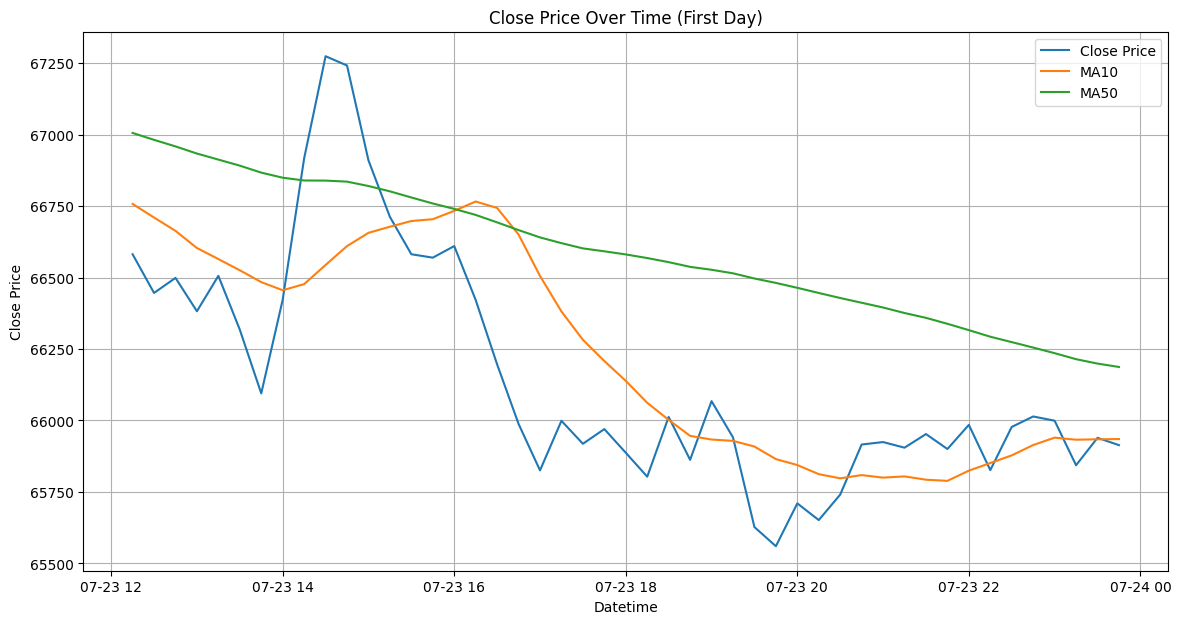

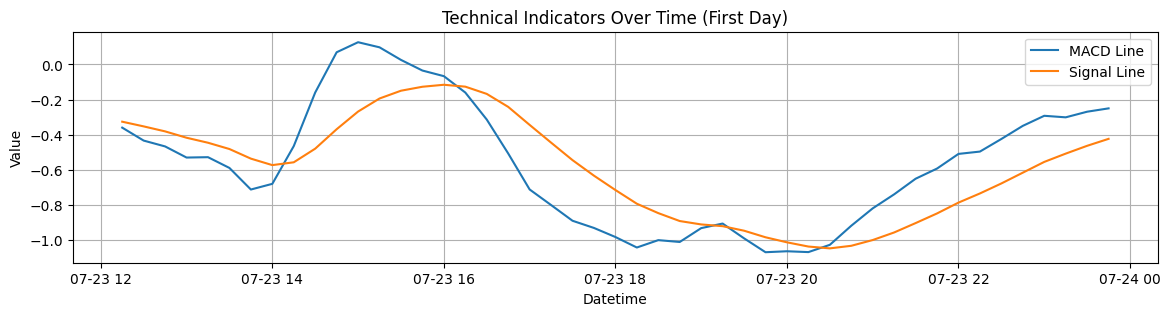

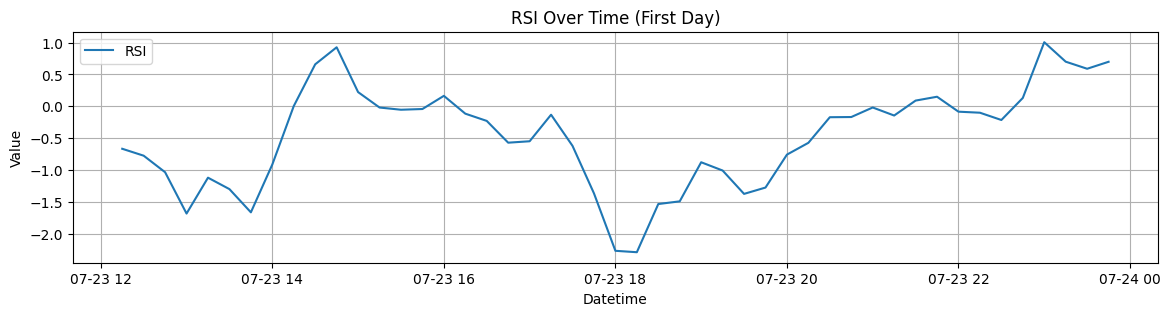

In [7]:
import matplotlib.pyplot as plt

plot_data = data_scaled#.loc[data_scaled.index.date == data_scaled.index[0].date()]

# Plot the 'Close' prices for the first day
plt.figure(figsize=(14, 7))
plt.plot(plot_data.index, plot_data['Close'], label='Close Price')
plt.plot(plot_data.index, plot_data['MA10'], label='MA10')
plt.plot(plot_data.index, plot_data['MA50'], label='MA50')
plt.title('Close Price Over Time (First Day)')
plt.xlabel('Datetime')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot the technical indicators for the first day
plt.figure(figsize=(14, 3))
plt.plot(plot_data.index, plot_data['MACD_Line'], label='MACD Line')
plt.plot(plot_data.index, plot_data['Signal_Line'], label='Signal Line')
plt.title('Technical Indicators Over Time (First Day)')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the RSI for the first day
plt.figure(figsize=(14, 3))
plt.plot(plot_data.index, plot_data['RSI'], label='RSI')
plt.title('RSI Over Time (First Day)')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

3. Define the Target
You can define the target variable for training your model. A common approach is to predict the price direction (1 for upward movement, 0 for downward movement).

In [ ]:
def calculate_target(data, n_periods):
    """
    Create a target column based on the price performance over N periods.
    
    data: DataFrame
        The price data.
    n_periods: int
        Number of periods into the future to evaluate the target.
    """
    # Target: if Close price N periods ahead is greater than current Close price -> 1 (buy), else 0 (sell)
    data['Target'] = (data['Close'].shift(-n_periods)*1.000 > (data['Close'])).astype(int)
    
    data['Target_Return'] = (data['Close'].shift(-1) / (data['Close'])) - 1
    return data



# Choose the number of periods, e.g., N=5
N = 1
data_scaled = calculate_target(data_scaled, N)
print(data_scaled['Target'].value_counts())

print(data_scaled)

# Drop the last N rows as they won't have valid targets
data_scaled = data_scaled.dropna()




4. Train-Test Split
Before training the model, split your data into training and testing sets:

In [ ]:

#add target return to features. This is used later so that we can calculate the return of the model over and above a simple binary classification.

print(features)
expandedfeatures = features.copy()
expandedfeatures.append('Target_Return')
print(expandedfeatures)

X = data_scaled[expandedfeatures]
y = data_scaled['Target']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


# Drop the target columns from the feature sets
Target_Return = X_test['Target_Return']
X_train = X_train.drop(columns=['Target_Return'])
X_test = X_test.drop(columns=['Target_Return'])

#print(Target_Return)


5. Train a Logistic Regression Model
Logistic regression is a simple model you can use as a starting point:

In [ ]:

# Train the logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


model = LogisticRegression(max_iter=500)

model.fit(X_train, y_train)

# Make probability predictions
y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Get the weights (coefficients)
weights = model.coef_

print("Model Weights:", weights)


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming X is your features matrix and y is your target (e.g., next price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop the target columns from the feature sets
Target_Return = X_test['Target_Return']
X_train = X_train.drop(columns=['Target_Return'])
X_test = X_test.drop(columns=['Target_Return'])

model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05)
print(X_train)
print(y_train)

model.fit(X_train, y_train)

y_proba = model.predict(X_test)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Assuming `data` is your 15-minute interval stock price data
data_scaled = data.copy()
features = ['MA10_pct', 'MA50_pct', 'Pct_Change', 'HL_Spread', 'RSI', 'MACD_pct', 'Signal_pct', 'MACD_Histogram']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Can adjust based on experimentation
X, y = create_sequences(scaled_data, seq_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=64)

predictions = model.predict(X_test)

Look at the accuracy of the model

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np


# Set your custom threshold (e.g., 0.6 for higher confidence)
#threshold = 0.65
#y_pred_adjusted = (y_proba >= threshold).astype(int)

# Evaluate the model with the adjusted threshold
#accuracy = accuracy_score(y_test, y_pred_adjusted)
#print(f"Model Accuracy with threshold {threshold} for N={N} periods: {accuracy:.2f}")

threshold = 0.5
y_pred_adjusted = (y_proba >= threshold).astype(int)

#print(y_proba)
combined_data = pd.DataFrame({'y_proba': y_proba, 'Target_Return': Target_Return})
#print(combined_data)

predicted_positive_returns = combined_data[combined_data['y_proba'] > threshold]

average_target_return = predicted_positive_returns['Target_Return'].mean()
average_target_return_pos = predicted_positive_returns[predicted_positive_returns['Target_Return'] > 0]['Target_Return'].mean()
average_target_return_neg = predicted_positive_returns[predicted_positive_returns['Target_Return'] < 0]['Target_Return'].mean()

print(f"Average Target Return {average_target_return * 10000:.2f}bps (Positive/Negative): {average_target_return_pos * 10000:.2f}bps/{average_target_return_neg * 10000:.2f}bps")

conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
true_positives = conf_matrix[1, 1]
false_positives = conf_matrix[0, 1]
ratio = true_positives / false_positives
print(f"Threshold: {threshold:.2f}, Ratio of True Positives {true_positives} to False Positives {false_positives}: {ratio:.2f}, Average Target Return: {average_target_return * 10000:.2f}bps")

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

thresholds = np.arange(0.4, 0.82, 0.02)
for threshold in thresholds:
    y_pred_adjusted = (y_proba >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
    true_positives = conf_matrix[1, 1]
    false_positives = conf_matrix[0, 1]
    ratio = true_positives / false_positives
    print(f"Threshold: {threshold:.2f}, Ratio of True Positives {true_positives} to False Positives {false_positives}: {ratio}")
    

In [ ]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
print(conf_matrix)

true_positives = conf_matrix[1, 1]
false_positives = conf_matrix[0, 1]
ratio = true_positives / false_positives
print("Ratio of True Positives to False Positives:", ratio)

In [ ]:
import joblib

# Save the model
joblib.dump(model, 'logistic_regression_model.pkl')
joblib.dump(scaler, 'logistic_regression_scaler.pkl')